## 👩🏽‍⚕️ Health Challenge - 2023

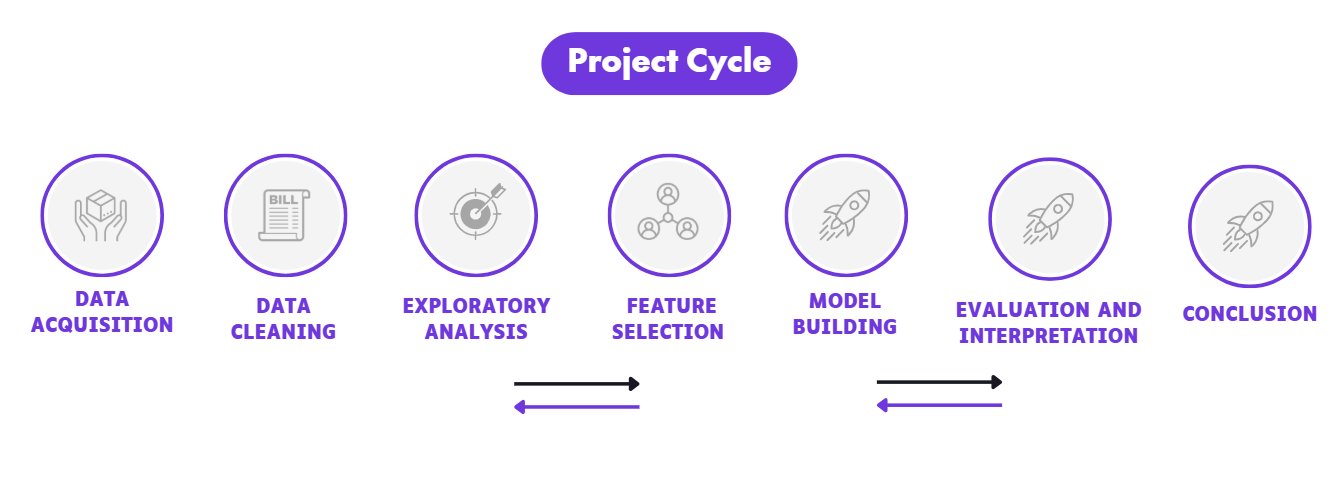

#### 💬 Project Summary

This project was challenging and engaging, as it combined multiple data science concepts and techniques in a scenario close to a real-world business problem—where conditions are rarely ideal, but insights and value can still be extracted.

Below is a brief overview of the project stages, including some analyses and approaches tested but not included in the final document.

🧩 Problem Definition

We aim to classify the presence of a critical health condition using up to 100 carefully selected variables from a set of 1,000. Since the variables are unlabeled and the target condition is unclear, assessing predictability is challenging.

⚙️ Preprocessing

Data Cleaning: Columns with >30% missing values were removed; remaining missing values were filled with the median, which is more robust to outliers than the mean.

Imbalanced Dataset: SMOTE oversampling was used to address the 86% negative class imbalance, yielding better performance than undersampling or class weights.

Feature Selection: High dimensionality required reducing variables. Methods tested included KS test, Boruta, correlation filtering, and Random Forest filtering. KS test was chosen for computational efficiency.

Feature Engineering: Not applied due to lack of variable descriptions.

Scaling: Not necessary as chosen models are scale-invariant.

📊 Exploratory Analysis

Due to the absence of variable meaning, exploratory analysis was limited to correlation, KS tests, and class balance checks to guide preprocessing and modeling.

🔮 Modeling

Three models were selected for final testing—Logistic Regression, Decision Tree, and XGBoost—after reviewing multiple options with PyCaret AutoML. Logistic Regression performed best; hyperparameter tuning via GridSearch did not improve ROC-AUC.

📝 Evaluation and Interpretation

Key evaluation metrics include ROC-AUC, confusion matrix, decile target rates, precision, and recall. Explainability is crucial in health-related problems; SHAP values were used to interpret model decisions, though their insights are limited without variable context.

#### 📚 Installing and importing the necessary packages

In [ ]:
pip install pycaret

In [ ]:
pip install shap

In [ ]:
pip install boruta

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
from boruta import BorutaPy
from scipy.stats import ks_2samp
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel


import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import linear_model, decomposition, datasets
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.style.use('ggplot')
sns.set_palette('Blues')
sns.set_style('whitegrid', {'axes.spines.left': True,
                            'axes.spines.bottom': True,
                            'axes.spines.right': True,
                            'axes.spines.top': True})

#### 🔁 Connecting Google Colab to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### 🎲 Loading the data

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/Projetos ML/Desafio Saúde - Neuro/Cópia de train')

In [9]:
test_df = pd.read_csv('/content/drive/MyDrive/Projetos ML/Desafio Saúde - Neuro/Cópia de test')

#### 👀 Inspecting the overall structure of the data

In [10]:
train_df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,2142.0,4397.0,8978.0,17329.0,25324.0,1515.0,3053.0,6295.0,12179.0,17714.0,...,0.00,0.00,0.00,0.00,0.00,0.00,3849.11,1.0,0,0
1,4230.0,8477.0,16253.0,31545.0,46576.0,3151.0,6286.0,12021.0,23391.0,34501.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
2,123016.0,253889.0,479469.0,949783.0,1423562.0,84625.0,173262.0,327248.0,648115.0,971543.0,...,2872.32,2872.32,1217.18,12423.70,21092.96,35177.31,66642.75,13.0,0,0
3,7646.0,15987.0,31309.0,60711.0,88139.0,5760.0,11899.0,23219.0,45452.0,66126.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
4,5442.0,10358.0,20710.0,40147.0,61672.0,1940.0,3900.0,7825.0,15161.0,22792.0,...,1045782.67,1645343.02,245300.63,514644.76,1628928.12,3211634.36,6019027.97,3940.0,0,0


In [11]:
test_df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var992,var993,var994,var995,var996,var997,var998,var999,var1000,alvo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0,0
1,1833.0,3745.0,3745.0,3745.0,3745.0,1314.0,2619.0,2619.0,2619.0,2619.0,...,0.00,0.00,199.33,944.33,1602.42,1602.42,1602.42,3.0,0,0
2,5077.0,10747.0,19337.0,35050.0,49748.0,3740.0,7885.0,14069.0,25651.0,36413.0,...,0.00,0.00,0.00,0.00,0.00,4925.56,4925.56,1.0,0,0
3,6145.0,12540.0,24752.0,49255.0,73599.0,3120.0,6436.0,12530.0,24554.0,36307.0,...,957.44,24444.31,0.00,0.00,0.00,123870.68,193836.09,40.0,0,0
4,12766.0,25627.0,41590.0,41590.0,41590.0,8516.0,17013.0,27721.0,27721.0,27721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 305.5 MB


#### 🧹🪣 Handling rows with missing values

In [13]:
print('Number of missing values per column in the training dataset:\n', train_df.isnull().sum().sort_values(ascending=False))

Number of missing values per column in the training dataset:
 var586     18418
var584     18418
var576     18418
var577     18418
var578     18418
           ...  
var517      2793
var516      2793
var515      2793
var1000        0
alvo           0
Length: 1001, dtype: int64


The first step to handle these missing values is to remove columns with a relatively high number of nulls. We'll use a 30% threshold for discarding: columns with more than 30% null values will be removed.

In [14]:
train_df_filtered = train_df.loc[:, (train_df.isnull().sum() / train_df.shape[0]) < 0.3]

In [15]:
train_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 979 entries, var1 to alvo
dtypes: float64(977), int64(2)
memory usage: 298.8 MB


Next, we need to apply the same removals to the test dataset so that the columns remain consistent.

In [16]:
test_df_filtered = test_df.loc[:, (train_df.isnull().sum() / train_df.shape[0]) < 0.3]

In [17]:
test_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 979 entries, var1 to alvo
dtypes: float64(977), int64(2)
memory usage: 74.7 MB


In [18]:
print('Maximum number of null values in a column in the training dataset (after filtering):', train_df_filtered.isnull().sum().max())

Maximum number of null values in a column in the training dataset (after filtering): 9238


After that, there are still columns with missing values. We'll fill these using the mean of the respective column.

In [19]:
imputer = SimpleImputer(strategy='median',
                        missing_values=np.nan)

imputer = imputer.fit(train_df_filtered)

train_df_imputed = pd.DataFrame(imputer.transform(train_df_filtered.loc[:,:]),
                  columns = train_df_filtered.columns)

Again, we will apply the same changes to the test dataset, using the mean calculated from the training set, assuming both datasets follow the same distribution.

In [20]:
test_df_imputed = pd.DataFrame(imputer.transform(test_df_filtered.loc[:,:]),
                  columns = test_df_filtered.columns)

In [21]:
print('Maximum number of null values in the training dataset columns:', train_df_imputed.isnull().sum().max())
print('Maximum number of null values in the test dataset columns:', test_df_imputed.isnull().sum().max())

Maximum number of null values in the training dataset columns: 0
Maximum number of null values in the test dataset columns: 0


#### 🔎📊 Exploratory Analysis

##### 🧲 Correlation Analysis

In [22]:
X_train = train_df_imputed.drop('alvo', axis = 1)
y_train = train_df_imputed['alvo']

correlation_values = X_train.corrwith(y_train)
correlation_values.abs().sort_values(ascending=False)

,0
var1000,1.000000
var453,0.057495
var394,0.057446
var362,0.057440
var374,0.056835
...,...
var48,0.000129
var419,0.000111
var46,0.000074
var909,0.000047


From the correlation analysis between the explanatory variables and the target, we can already see an indication that the predictive power is likely low. Another observation is that var1000 shows a positive correlation with the target—it might be conveying the same information; we will investigate this further later.

It is important to note that there might be non-linear correlations between these variables that Pearson’s test cannot capture.

##### ⚖️ Balance Analysis

For problems related to detecting critical health conditions, it is common to observe that the target distribution is imbalanced. This makes sense: in a large sample, only a few individuals are expected to actually have the condition.

Understanding this distribution is essential, because training the model with the data as-is may prevent it from learning patterns related to the underrepresented class.

In [23]:
train_df['alvo'].value_counts()

,count
alvo,
0,34565
1,5435


In [25]:
print('Percentage of negative observations for critical condition:', train_df['alvo'].value_counts()[0] / train_df.shape[0])
print('Percentage of positive observations for critical condition:', train_df['alvo'].value_counts()[1] / train_df.shape[0])

Percentage of negative observations for critical condition: 0.864125
Percentage of positive observations for critical condition: 0.135875


Text(0.5, 1.0, 'Target variable distribution \n (0: Negative for critical condition | 1: Positive for critical condition)')

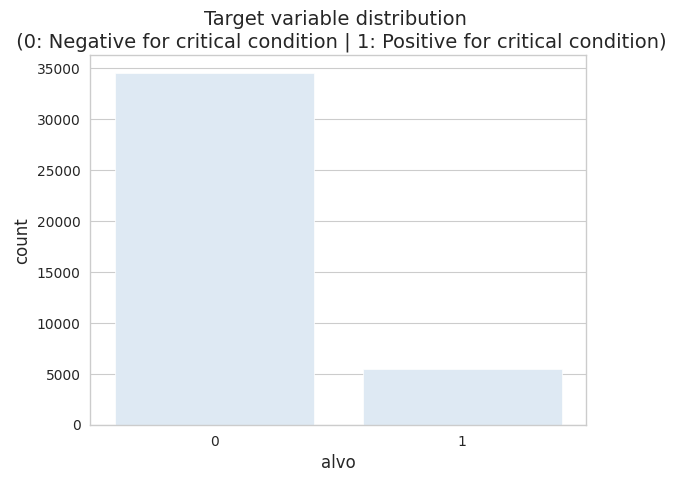

In [26]:
sns.countplot(x='alvo', data=train_df)
plt.title('Target variable distribution \n (0: Negative for critical condition | 1: Positive for critical condition)', fontsize=14)

**Best practices for handling an imbalanced dataset:**

1. Evaluate the correct metrics: Metrics like accuracy can be misleading in imbalanced datasets, as a model that always predicts the majority class can still have high accuracy. It is therefore important to use metrics such as precision, recall, F1-score, and ROC-AUC, which account for class imbalance.

2. Use resampling techniques: Re-sampling techniques such as oversampling and undersampling can help balance class distributions. Oversampling creates new samples for the minority class—for example, SMOTE (Synthetic Minority Over-sampling Technique) generates new samples based on existing minority samples. Undersampling, on the other hand, removes samples from the majority class.

Before addressing the class imbalance problem, we first select the most important variables for predicting our target. Feature selection aims to:

- Reduce dimensionality

- Eliminate irrelevant features to avoid noise

- Reduce overfitting risk

- Improve interpretability and model communication

#### ✅ Feature Selection (KS Test)

The Kolmogorov-Smirnov (KS) test is a non-parametric statistical test used to compare two samples or to test whether a sample follows a specific theoretical distribution.

It is used to evaluate whether there are significant differences between the empirical distributions of two groups being compared, or between the empirical distribution of a sample and the expected theoretical distribution.

When using this test as a feature selection tool, we aim to understand how well our variables can "separate" the target. By comparing the distribution of a variable when the target is 1 with its distribution when the target is 0, we can identify variables that are good candidates if their distributions differ significantly, meaning they have strong explanatory power for the target.

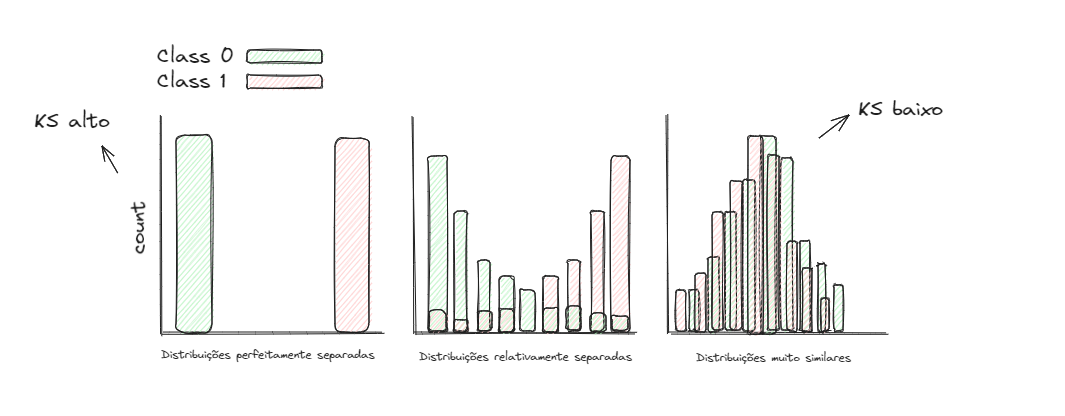

In [27]:
ks_values = []

for col in train_df_imputed.columns:
    if col == 'alvo':
        continue
    ks_stat = ks_2samp(train_df_imputed.loc[train_df_imputed.alvo == 0 ][col], train_df_imputed.loc[train_df_imputed.alvo == 1][col])[0]
    ks_values.append(ks_stat)

ks_results = pd.DataFrame(zip(train_df_imputed.columns, ks_values), columns=['col', 'ks_stat']).sort_values(by='ks_stat', ascending=False)

columns_to_remove = ks_results.tail(ks_results.shape[0] - 100)['col']

In [28]:
ks_results.head(10)

,col,ks_stat
977,var1000,1.000000
456,var458,0.071183
451,var453,0.068940
439,var441,0.068791
393,var395,0.068695
361,var363,0.068695
447,var449,0.068646
428,var430,0.068455
436,var438,0.068262
387,var389,0.067802


It can be observed that many variables seem to have low predictive power, since a KS close to 0 indicates that the distributions are similar for both classes of the target.

Generally, a variable can be considered:

- Good (KS ~ 0.15)

- Very good (KS ~ 0.20)

- Excellent (KS ~ 0.30)

In [29]:
train_df_selected = train_df_imputed.drop(columns=columns_to_remove)
test_df_selected = test_df_imputed.drop(columns=columns_to_remove)

The higher the KS value, the better! However, a KS = 1 is a warning sign, as it likely indicates that the variable is a mirror of the target. This can cause the model to simply memorize results and perform poorly when generalizing.

In [30]:
train_df_selected.drop('var1000', axis=1, inplace=True)
test_df_selected.drop('var1000', axis=1, inplace=True)

#### 👥 Applying SMOTE to handle the imbalanced target variable

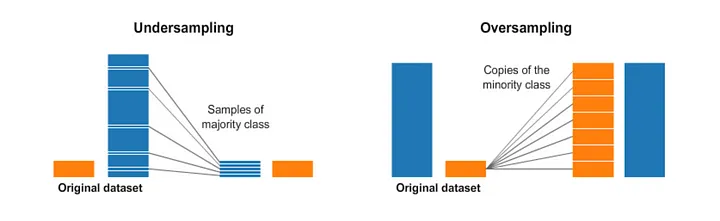

I chose to use oversampling to avoid the data loss that occurs with undersampling when reducing the majority class.

SMOTE is an oversampling technique that generates new examples of the minority class by interpolating between its nearest neighbors.

In other words, by drawing lines between the nearest neighbors of a minority class datapoint, we can create new datapoints “along” that line, so they have similar characteristics to the original observations but are not exact copies.

It is important to apply resampling techniques only to the training set and keep a test set that represents the real problem, ensuring representativeness and avoiding data leakage and overfitting.

In [31]:
X_train = train_df_selected.drop('alvo', axis=1)
y_train = train_df_selected['alvo']

In [32]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

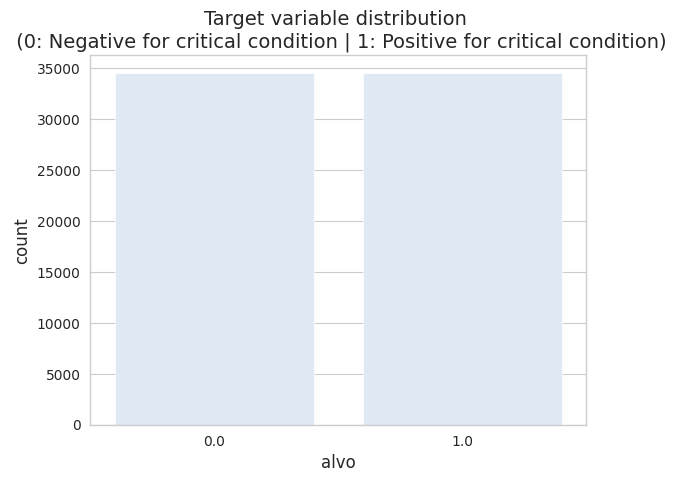

In [34]:
sns.countplot(data=pd.concat([X_train_balanced, y_train_balanced], axis=1), x='alvo')
plt.title('Target variable distribution \n (0: Negative for critical condition | 1: Positive for critical condition)', fontsize=14)
plt.show()

In [35]:
print('Percentage of negative observations for critical condition:', y_train_balanced.value_counts()[0] / y_train_balanced.shape[0])
print('Percentage of positive observations for critical condition:', y_train_balanced.value_counts()[1] / y_train_balanced.shape[0])

Percentage of negative observations for critical condition: 0.5
Percentage of positive observations for critical condition: 0.5


#### 🤖 Model Selection

First, let’s see how the model behaves when trained with all* available variables and without balancing the samples.

*Except var1000, which we already saw mirrors the target variable!

In [36]:
X_train_all = train_df_imputed.drop(columns=['alvo', 'var1000'])
y_train_all = train_df_imputed['alvo']

X_test_all = test_df_imputed.drop(columns=['alvo', 'var1000'])
y_test_all = test_df_imputed['alvo']

logr = LogisticRegression()
logr.fit(X_train_all, y_train_all)

y_pred_logr = logr.predict(X_test_all)

In [37]:
print(classification_report(y_test_all, y_pred_logr))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93      8641
         1.0       0.00      0.00      0.00      1359

    accuracy                           0.86     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.75      0.86      0.80     10000



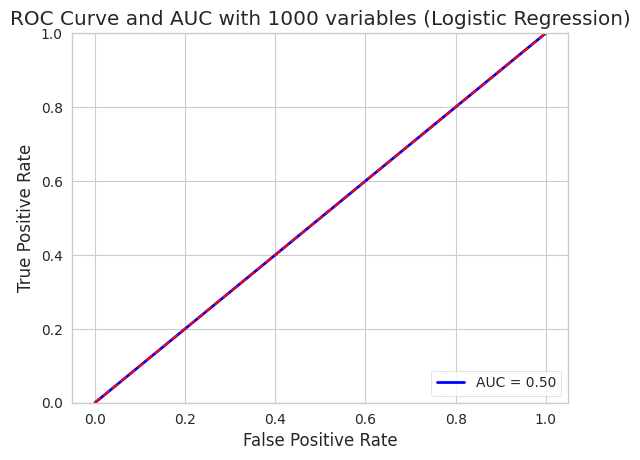

In [38]:
fpr, tpr, threshold = roc_curve(y_test_all, y_pred_logr)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve and AUC with 1000 variables (Logistic Regression)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=2)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model behaves like a random classifier! We expect that feature selection and sample balancing will help improve performance.

**Model Testing**

- Logistic Regression

- Decision Tree

- XGBoost Classifier

**Why did I choose this subset of 3 classifiers specifically for our dataset?**

Mainly because these models handle numerical data well, cope with high dimensionality, offer good interpretability (essential for health-related problems), and have proven performance in classification tasks.

Additionally, each has a different level of complexity and learning characteristics. Testing models with these differences is important to discover which one fits our dataset best and why.

#### 🗂️ Defining the feature matrix and target vector

In [39]:
X_train = X_train_balanced
y_train = y_train_balanced


X_test = test_df_selected.drop('alvo', axis=1)
y_test = test_df_selected['alvo']

#### 🔮 Using the Logistic Regression Classifier

Logistic regression is a machine learning algorithm used to solve classification problems—i.e., problems where the target variable has two or more distinct classes. The goal of logistic regression is to find a function that models the relationship between the independent variables (features) and the probability of belonging to a specific class.

Logistic regression uses the logistic function, also known as the sigmoid function. The logistic function transforms input values into a range between 0 and 1, which can be interpreted as the probability of belonging to the positive class.

The logistic function is defined as:

$
{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$

where 𝑧 is a linear combination of the features and their corresponding weights:

$z = w0 + w1*x1 + w2*x2 + ... + wn*xn$

The training process of logistic regression involves finding the optimal values for the weights (w0, w1, ..., wn) in order to minimize the cost function.

Once the model is trained, it can be used to make predictions on new observations. The logistic function is applied to the input values weighted by the coefficients, and the result is interpreted as the probability of belonging to the positive class.

Logistic regression is a simple yet effective algorithm, widely used for binary classification problems—which is exactly our case.

##### 🏋️ [Logistic Regression] Training...

In [40]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

##### 🤔 [Logistic Regression] Analyzing Model Results

In [41]:
y_pred_reg = logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

         0.0       0.88      0.45      0.60      8641
         1.0       0.15      0.62      0.24      1359

    accuracy                           0.48     10000
   macro avg       0.52      0.54      0.42     10000
weighted avg       0.78      0.48      0.55     10000



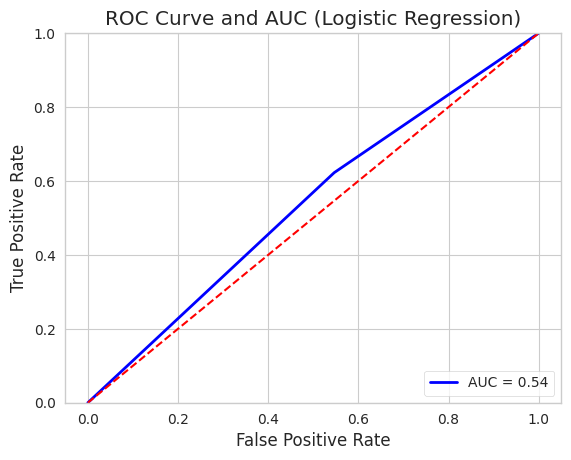

In [42]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_reg)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve and AUC (Logistic Regression)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc, linewidth=2)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 🔮 Using the Decision Tree Classifier


A decision tree is a tree-shaped structure composed of nodes and edges. Each internal node represents a test on a specific feature, while each leaf represents a class or target value. The goal is to split the dataset into the purest possible subsets—i.e., subsets where instances share the same class.

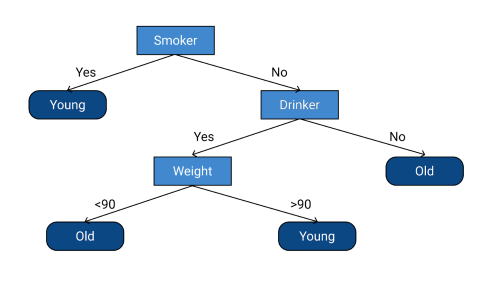

Decision trees are simple, easy-to-understand, and interpretable models. They can handle numerical data, making them suitable for our dataset composed of numeric variables. Additionally, decision trees can identify non-linear relationships between features and the target, which can be useful for our classification task.

##### 🏋️ [Decision Tree] Training...

In [43]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

##### 🤔 [Decision Tree] Analyzing Model Results

In [44]:
y_pred_dtree = dtree.predict(X_test)
print('Decision Tree Classification Report:')
print(classification_report(y_test, y_pred_dtree))

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.65      0.74      8641
         1.0       0.15      0.39      0.21      1359

    accuracy                           0.61     10000
   macro avg       0.51      0.52      0.48     10000
weighted avg       0.77      0.61      0.67     10000



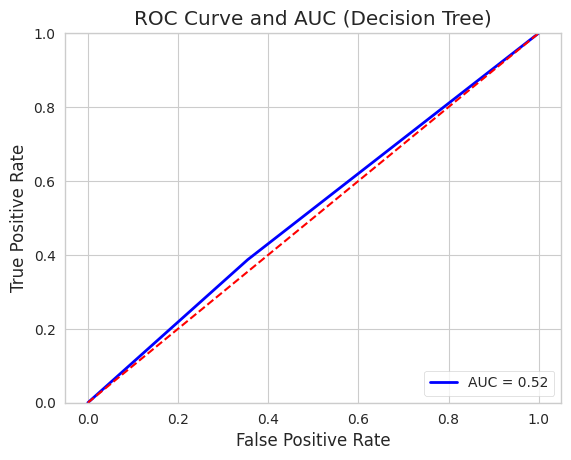

In [45]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_dtree)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve and AUC (Decision Tree)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc, linewidth=2)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 🔮 Using the XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a tree-based machine learning algorithm designed for classification and regression problems. It is an optimized and highly efficient implementation of Gradient Boosting, a sequential boosting technique.

A Gradient Boosting Decision Trees algorithm is an ensemble learning method based on decision trees, similar to Random Forest. Ensemble learning algorithms combine multiple machine learning models to create a stronger overall model.

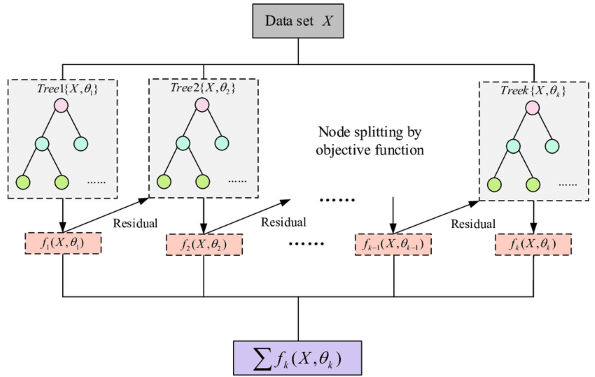

XGBoost is known for its computational efficiency and ability to handle large datasets. It also provides advanced features such as regularization, handling missing data, and support for multiple evaluation metrics.

##### 🏋️ [XG Boost] Training...

In [46]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

##### 🤔 [XGBoost] Analyzing Model Results

In [47]:
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72      8641
         1.0       0.15      0.44      0.23      1359

    accuracy                           0.59     10000
   macro avg       0.51      0.53      0.47     10000
weighted avg       0.78      0.59      0.65     10000



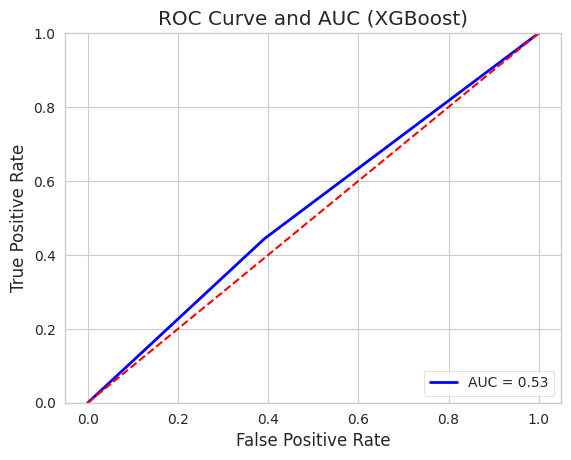

In [48]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve and AUC (XGBoost)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc, linewidth=2)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 📝 Performance Analysis and Final Model Interpretation

##### 🔹 **ROC and AUC curve**

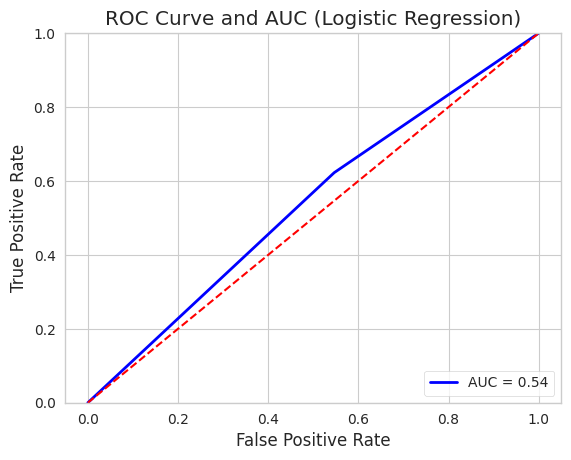

In [49]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_reg)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve and AUC (Logistic Regression)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc, linewidth=2)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### 🔹 **Confusion Matrix**

In [50]:
cm = confusion_matrix(y_test, y_pred_reg, normalize='true')

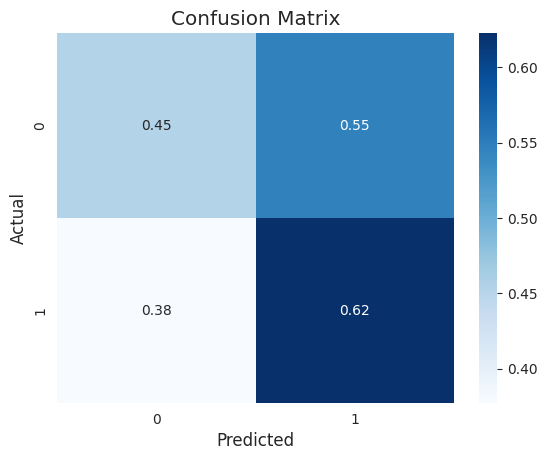

In [51]:
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

The confusion matrix results can vary depending on the chosen classification threshold. Usually, this threshold is set together with domain experts to balance false positives and false negatives.

 ##### 🔹 **Target Rate in Decile 10 and Target Rate in Percentile 100**

###### Defining the plot function

In [52]:
def target_rate_by_quantile(target, scores, quantiles, lower_limit=None):

    labelscore = pd.DataFrame(
        zip(target, scores),
        columns=['label', 'score']).sort_values(by='score')

    labelscore['quantile'] = pd.qcut(labelscore['score'], quantiles, labels=range(1,1+quantiles))

    if lower_limit:
        labelscore = labelscore.loc[labelscore['quantile'] > lower_limit]

    chart_df = pd.DataFrame(zip(
      labelscore.groupby('quantile')['label'].mean(), labelscore.groupby('quantile')['label'].size()/labelscore.shape[0]
      ), columns=['target_rate', 'population'])

    fig = make_subplots()

    chart_df = chart_df.dropna()

    fig.add_trace(
      go.Scatter(x=chart_df.index.to_list(), y=chart_df.target_rate, name="Target Mean", marker_color="red")
    )

    fig.add_hline(y=np.mean(target), line_dash="dash", line_color="blue")

    fig.add_annotation(
        x=8.2, y=np.mean(target)-0.003,
        xref="x", yref="y",
        text=f"Target Mean: {np.mean(target)}",
        showarrow=False,
        font=dict(color="blue")
    )

    fig.update_layout(xaxis_range=[0, quantiles-1])
    fig.update_xaxes(title_text='Population Decile')

    fig.update_layout(
      width=1000, height=500,
      legend=dict(orientation="h", xanchor='center', x=0.5, y=-0.2),
      xaxis=dict(tickmode='linear')
    )

    fig.show()

###### Plot visualization by decile

In [53]:
target_rate_by_quantile(y_test, logisticRegr.predict_proba(X_test)[:,1], 10, lower_limit=None)

By ordering the score vector and splitting by deciles, we see that the last decile concentrates observations with the highest probability of belonging to the positive class according to the model. The red line indicates the target rate in each population decile.

As we can see, in the last decile there is a lift of ~26% compared to the population mean, and the curve shows an increasing trend. This indicates that the model is effectively stratifying the population according to risk.

###### Scores by Percentile

In [54]:
labelscore = pd.DataFrame(
        zip(y_test, logisticRegr.predict_proba(X_test)[:,1]),
        columns=['label', 'score']).sort_values(by='score', ascending=False)

In [55]:
labelscore.head(100).mean()

,0
label,0.18000
score,0.58456


It was expected that the last percentile would show a higher lift than the last decile, since we are narrowing the analysis to cases with an even higher probability.

However, this result did not occur. This may indicate that the model could benefit from further refinement to better stratify cases in this scenario. A valid approach would be to study how we can adjust the logistic regression hyperparameters to better achieve our objective.

##### 🔹 **SHAP Values**

In [56]:
explainer_clf = shap.Explainer(logisticRegr.predict, X_test)
shap_values_clf = explainer_clf(X_test)

PermutationExplainer explainer: 10001it [09:27, 17.49it/s]                          


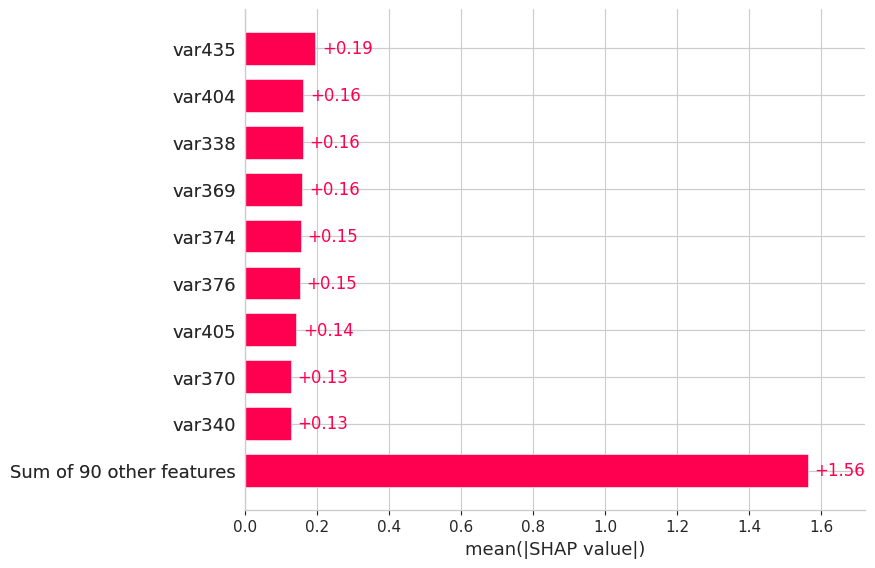

In [57]:
shap.plots.bar(shap_values_clf)

The top 10 variables in the SHAP plot are the most important for our model. Together, they account for about 46% of the impact on the target prediction.

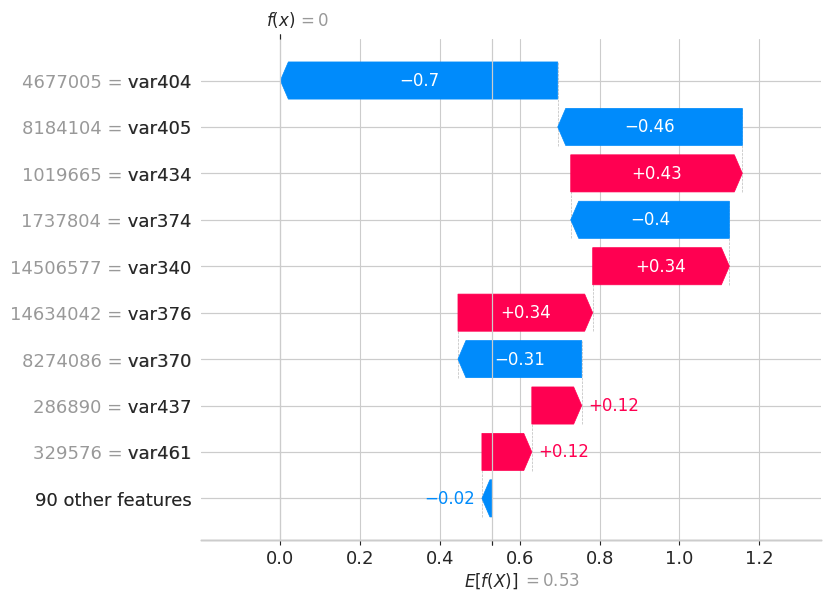

In [58]:
shap.plots.waterfall(shap_values_clf[0])

This plot is particularly useful when we know the meaning of the variables, as it allows us to analyze how the model made a decision for a given observation and which predictor variables influenced the outcome.

It is a powerful tool for communicating the results of modeling projects.

#### 🧠 Conclusions and Critical Analysis of Results


An AUC (area under the ROC curve) of **0.54** indicates that our model’s performance is only slightly better than a random classifier. It is important to investigate the potential causes of this low performance before considering the model useful for supporting business decisions.

There are several reasons why the model might not be producing satisfactory results:

- **Data Quality:** It is important to evaluate the quality of the selected features and whether they truly contain relevant information for predicting our target. Since we have variables with generic descriptions (var1, var2, ...), it is not possible to critically assess whether these variables make sense for our target or perform feature engineering.

- **Missing Information:** It is important to consider whether additional information could be collected and incorporated into the dataset, providing more predictive power for the model.

Another point of attention regarding model performance and the relationship between variables is the KS (Kolmogorov-Smirnov) value.

This metric is commonly used to evaluate a variable’s ability to “separate” the classes with respect to the target. A **maximum KS of 0.07** indicates that the variables have a low capacity to distinguish between classes 0 and 1.

This reinforces the evidence that the selected variables may not contain enough predictive information to correctly forecast the target. A KS value close to zero indicates that the variable distributions are similar for both classes, making it difficult for the model to reliably distinguish between them.

Regarding the model’s usefulness in a business context, an AUC of 0.54 is generally considered weak, but it can still be used carefully—particularly when analyzing the last decile and/or the last percentile, where the target hit rate was higher.